# Feature Creation Using Yelp and Zillow Data Set

## Machine Learning Problem

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import sqlite3
import dateutil.parser as parser
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pickle

## Yelp Data Set extraction: Pittsburgh businesses by ZipCode

In [3]:
#Create Database Connection
DBName = 'yelp_project.db'
conn=sqlite3.connect(DBName)
cursor = conn.cursor()

In [4]:
#Read Business Data and query data from reviews
query = "SELECT b.business_id, r.stars, attributes, date, useful, cool, funny, postal_code FROM review r JOIN \
business b USING (business_id) WHERE CAST(postal_code AS int)>=15000 AND CAST(postal_code AS int)<15500"
business_data = pd.read_sql_query(query,conn)
business_data.head()

,business_id,stars,attributes,date,useful,cool,funny,postal_code
0,cnGIivYRLxpF7tBVR_JwWA,1,"['AcceptsInsurance: False', 'BusinessAcceptsCr...",2016-02-01,0,0,0,15071
1,cnGIivYRLxpF7tBVR_JwWA,5,"['AcceptsInsurance: False', 'BusinessAcceptsCr...",2016-07-04,0,0,0,15071
2,cnGIivYRLxpF7tBVR_JwWA,5,"['AcceptsInsurance: False', 'BusinessAcceptsCr...",2016-07-28,0,0,0,15071
3,cnGIivYRLxpF7tBVR_JwWA,5,"['AcceptsInsurance: False', 'BusinessAcceptsCr...",2016-08-06,0,0,0,15071
4,P3LisOj7DktgGa7C5FYpnA,1,['BusinessAcceptsCreditCards: True'],2015-09-19,4,0,0,15237


In [5]:
#Split the column attributes one per row 
attributes_splitted = pd.concat([pd.Series(row['business_id'],row['attributes'].split(',')) for _, row in business_data.dropna().iterrows()]).reset_index()
attributes_splitted.columns = ['Attributes', 'business_id']

In [6]:
attributes_splitted.head()

,Attributes,business_id
0,['AcceptsInsurance: False',cnGIivYRLxpF7tBVR_JwWA
1,'BusinessAcceptsCreditCards: True',cnGIivYRLxpF7tBVR_JwWA
2,"""BusinessParking: {'garage': False",cnGIivYRLxpF7tBVR_JwWA
3,'street': False,cnGIivYRLxpF7tBVR_JwWA
4,'validated': False,cnGIivYRLxpF7tBVR_JwWA


In [8]:
#Get Restaurants with price
restprice = attributes_splitted[attributes_splitted.Attributes.str.contains("restaurantspricerange", case=False)].reset_index()
restprice.head()

,index,Attributes,business_id
0,16,'RestaurantsPriceRange2: 3'],cnGIivYRLxpF7tBVR_JwWA
1,33,'RestaurantsPriceRange2: 3'],cnGIivYRLxpF7tBVR_JwWA
2,50,'RestaurantsPriceRange2: 3'],cnGIivYRLxpF7tBVR_JwWA
3,67,'RestaurantsPriceRange2: 3'],cnGIivYRLxpF7tBVR_JwWA
4,124,'RestaurantsPriceRange2: 2',93otbGHE0s0m-lU1osvg9w


In [9]:
#Extract price range and remove non-numerical characters
restprice['Price'] = [ pd.to_numeric(re.sub(r"[\[\]' ]", "", r.split(":")[1])) for r in restprice.Attributes]
restprice.head()

,index,Attributes,business_id,Price
0,16,'RestaurantsPriceRange2: 3'],cnGIivYRLxpF7tBVR_JwWA,3
1,33,'RestaurantsPriceRange2: 3'],cnGIivYRLxpF7tBVR_JwWA,3
2,50,'RestaurantsPriceRange2: 3'],cnGIivYRLxpF7tBVR_JwWA,3
3,67,'RestaurantsPriceRange2: 3'],cnGIivYRLxpF7tBVR_JwWA,3
4,124,'RestaurantsPriceRange2: 2',93otbGHE0s0m-lU1osvg9w,2


In [10]:
#keep business id and price column
business_price = restprice[['business_id', 'Price']]
business_price.head()

,business_id,Price
0,cnGIivYRLxpF7tBVR_JwWA,3
1,cnGIivYRLxpF7tBVR_JwWA,3
2,cnGIivYRLxpF7tBVR_JwWA,3
3,cnGIivYRLxpF7tBVR_JwWA,3
4,93otbGHE0s0m-lU1osvg9w,2


In [12]:
#Left Join of both business data and business price data frame
business_data_Price = business_data.join(business_price, how = 'left', rsuffix='_bp')
business_data_Price.head()

,business_id,stars,attributes,date,useful,cool,funny,postal_code,business_id_bp,Price
0,cnGIivYRLxpF7tBVR_JwWA,1,"['AcceptsInsurance: False', 'BusinessAcceptsCr...",2016-02-01,0,0,0,15071,cnGIivYRLxpF7tBVR_JwWA,3.0
1,cnGIivYRLxpF7tBVR_JwWA,5,"['AcceptsInsurance: False', 'BusinessAcceptsCr...",2016-07-04,0,0,0,15071,cnGIivYRLxpF7tBVR_JwWA,3.0
2,cnGIivYRLxpF7tBVR_JwWA,5,"['AcceptsInsurance: False', 'BusinessAcceptsCr...",2016-07-28,0,0,0,15071,cnGIivYRLxpF7tBVR_JwWA,3.0
3,cnGIivYRLxpF7tBVR_JwWA,5,"['AcceptsInsurance: False', 'BusinessAcceptsCr...",2016-08-06,0,0,0,15071,cnGIivYRLxpF7tBVR_JwWA,3.0
4,P3LisOj7DktgGa7C5FYpnA,1,['BusinessAcceptsCreditCards: True'],2015-09-19,4,0,0,15237,93otbGHE0s0m-lU1osvg9w,2.0


In [13]:
#Extract year from the date column
years=[pd.to_datetime(row['date']).year for _, row in business_data_Price.iterrows()]

In [14]:
#Veify Length of years
len(years)

176505

In [16]:
#include year column in the complete dataframe
business_data_Price['Years'] = years
business_data_Price.head()

,business_id,stars,attributes,date,useful,cool,funny,postal_code,business_id_bp,Price,Years
0,cnGIivYRLxpF7tBVR_JwWA,1,"['AcceptsInsurance: False', 'BusinessAcceptsCr...",2016-02-01,0,0,0,15071,cnGIivYRLxpF7tBVR_JwWA,3.0,2016
1,cnGIivYRLxpF7tBVR_JwWA,5,"['AcceptsInsurance: False', 'BusinessAcceptsCr...",2016-07-04,0,0,0,15071,cnGIivYRLxpF7tBVR_JwWA,3.0,2016
2,cnGIivYRLxpF7tBVR_JwWA,5,"['AcceptsInsurance: False', 'BusinessAcceptsCr...",2016-07-28,0,0,0,15071,cnGIivYRLxpF7tBVR_JwWA,3.0,2016
3,cnGIivYRLxpF7tBVR_JwWA,5,"['AcceptsInsurance: False', 'BusinessAcceptsCr...",2016-08-06,0,0,0,15071,cnGIivYRLxpF7tBVR_JwWA,3.0,2016
4,P3LisOj7DktgGa7C5FYpnA,1,['BusinessAcceptsCreditCards: True'],2015-09-19,4,0,0,15237,93otbGHE0s0m-lU1osvg9w,2.0,2015


In [18]:
#create dummy variables for the number of the stars

zip_matrix = business_data_Price[['postal_code', 'Years', 'stars', 'useful', 'funny', 'cool', 'Price']]
stars = zip_matrix.stars
zip_matrix = pd.get_dummies(zip_matrix, columns = ["stars"])
zip_matrix['stars'] = stars
zip_matrix.head()

,postal_code,Years,useful,funny,cool,Price,stars_1,stars_2,stars_3,stars_4,stars_5,stars
0,15071,2016,0,0,0,3.0,1.0,0.0,0.0,0.0,0.0,1
1,15071,2016,0,0,0,3.0,0.0,0.0,0.0,0.0,1.0,5
2,15071,2016,0,0,0,3.0,0.0,0.0,0.0,0.0,1.0,5
3,15071,2016,0,0,0,3.0,0.0,0.0,0.0,0.0,1.0,5
4,15237,2015,4,0,0,2.0,1.0,0.0,0.0,0.0,0.0,1


In [19]:
#aggregate the data by ZIPCODE, calculating the means of each feature
zip_aggregated = zip_matrix.groupby(['postal_code', 'Years']).agg(pd.Series.mean)
zip_aggregated.head()

useful  funny      cool     Price   stars_1  stars_2  \
postal_code Years                                                         
15003       2008    2.000  0.500  2.000000  3.000000  0.000000      0.0   
            2009    0.500  0.000  0.500000  2.000000  0.000000      0.0   
            2010    1.625  0.375  0.375000  2.500000  0.000000      0.0   
            2011    1.200  0.200  0.466667  2.500000  0.066667      0.0   
            2012    1.800  0.450  0.800000  2.066667  0.150000      0.1   

                    stars_3   stars_4   stars_5     stars  
postal_code Years                                          
15003       2008   0.000000  0.500000  0.500000  4.500000  
            2009   0.000000  0.500000  0.500000  4.500000  
            2010   0.125000  0.500000  0.375000  4.250000  
            2011   0.066667  0.133333  0.733333  4.466667  
            2012   0.050000  0.300000  0.400000  3.700000

In [23]:
#drop duplicates to have just one single price per business for each zipcode (the number of reviews do not matter)

business_price_zip = business_data_Price[['business_id','Price', 'postal_code', 'Years']].drop_duplicates()
price_zip = business_price_zip[['postal_code', 'Price', 'Years']]
price_zip.head()

,postal_code,Price,Years
0,15071,3.0,2016
4,15237,2.0,2015
5,15237,2.0,2014
6,15237,2.0,2016
7,15237,2.0,2011


In [24]:
#calculate the price
average_price_zip = price_zip.groupby(['postal_code','Years']).agg(pd.Series.mean)
average_price_zip.head()

Price
postal_code Years          
15003       2008   3.000000
            2009   2.000000
            2010   2.400000
            2011   2.400000
            2012   2.111111

In [25]:
#include the price column in the aggregated dataframe
zip_aggregated['Price'] = average_price_zip
zip_aggregated.head()

useful  funny      cool     Price   stars_1  stars_2  \
postal_code Years                                                         
15003       2008    2.000  0.500  2.000000  3.000000  0.000000      0.0   
            2009    0.500  0.000  0.500000  2.000000  0.000000      0.0   
            2010    1.625  0.375  0.375000  2.400000  0.000000      0.0   
            2011    1.200  0.200  0.466667  2.400000  0.066667      0.0   
            2012    1.800  0.450  0.800000  2.111111  0.150000      0.1   

                    stars_3   stars_4   stars_5     stars  
postal_code Years                                          
15003       2008   0.000000  0.500000  0.500000  4.500000  
            2009   0.000000  0.500000  0.500000  4.500000  
            2010   0.125000  0.500000  0.375000  4.250000  
            2011   0.066667  0.133333  0.733333  4.466667  
            2012   0.050000  0.300000  0.400000  3.700000

In [39]:
#Calculations to use in compuyting the proportion of reviews

average_reviews_zip = business_data_Price.groupby(['postal_code','Years']).agg(pd.Series.count)
average_reviews_zip = average_reviews_zip['business_id']
review_byzip = business_data_Price.groupby(['postal_code', 'Years']).count()
total_reviews = business_data_Price.groupby(['Years']).count().business_id
review_byzip = review_byzip.reset_index()[['postal_code','Years','business_id']]


In [40]:
#calculate the proportion of reviews that each zipcode has for each year
prop_reviews = [ float(review_byzip.ix[i]['business_id'])/total_reviews[review_byzip.ix[i]['Years']] for i in range(len(review_byzip))]

In [43]:
#include in aggreged data set
zip_aggregated['reviews_perc'] = prop_reviews
zip_aggregated.head()

In [46]:
#calculate the previous mean stars that the zipcode received in the previous year
flatten_zip = zip_aggregated.reset_index()
avg_review_prev1 = [flatten_zip[(flatten_zip['postal_code']==flatten_zip.ix[i]['postal_code'])&(flatten_zip['Years']==(flatten_zip.ix[i]['Years']-1))]['stars'].values for i in range(len(flatten_zip))]

In [48]:
#include the previous stat mean in the aggregated data frame
zip_aggregated['prev_stars'] = avg_review_prev1
zip_aggregated['prev_stars'] = zip_aggregated['prev_stars'].str.get(0)
zip_aggregated.head()

useful  funny      cool     Price   stars_1  stars_2  \
postal_code Years                                                         
15003       2008    2.000  0.500  2.000000  3.000000  0.000000      0.0   
            2009    0.500  0.000  0.500000  2.000000  0.000000      0.0   
            2010    1.625  0.375  0.375000  2.400000  0.000000      0.0   
            2011    1.200  0.200  0.466667  2.400000  0.066667      0.0   
            2012    1.800  0.450  0.800000  2.111111  0.150000      0.1   

                    stars_3   stars_4   stars_5     stars  reviews_perc  \
postal_code Years                                                         
15003       2008   0.000000  0.500000  0.500000  4.500000      0.001061   
            2009   0.000000  0.500000  0.500000  4.500000      0.000553   
            2010   0.125000  0.500000  0.375000  4.250000      0.001275   
            2011   0.066667  0.133333  0.733333  4.466667      0.001285   
            2012   0.050000  0.300000  0.400000  3.700000      0.001196   

                   prev_stars  
postal_code Years              
15003       2008          NaN  
            2009     4.500000  
            2010     4.500000  
            2011     4.250000  
            2012     4.466667

In [49]:
#save to pickle ------- Checkpoint
import pickle
output_file = open("Feature_Matrix_onlyYelp.dat","wb")
pickle.dump(zip_aggregated, output_file)
output_file.close()

## Zillow Data Set Extraction and Integration: Median price per square foot


In [50]:
#Integrate Zillow
zip_price = pd.read_csv("Zip_MedianValuePerSqft_AllHomes.csv")

#Select only Pittsburgh
pittsburgh_data_price = zip_price[(zip_price.RegionName>=15000)&(zip_price.RegionName<15500)]

#Select the RegionName and the columns with year
pittsburgh_data_byYear = pd.concat([pittsburgh_data_price.ix[:,1], pittsburgh_data_price[pittsburgh_data_price.columns[7:]]], axis = 1)

#Melt the dataframe to transform the columns into rows
flat_zip = pd.melt(pittsburgh_data_byYear, id_vars="RegionName", var_name="Date", value_name="MedSqft")
flat_zip.head()

,RegionName,Date,MedSqft
0,15301,1996-04,54.0
1,15237,1996-04,69.0
2,15108,1996-04,65.0
3,15068,1996-04,56.0
4,15235,1996-04,47.0


In [51]:
#Extract only the years
years = [flat_zip.Date.ix[i].split('-')[0] for i in range(len(flat_zip))]

#Add to df
flat_zip['Years'] = years

#Select only these columns
flat_zip = flat_zip[['RegionName', 'Years', 'MedSqft']]

#Group by and aggregate by median
med_zip = flat_zip.groupby(['RegionName', 'Years']).median()

#Flatten the table
med_zip = med_zip.reset_index()
med_zip.head()

,RegionName,Years,MedSqft
0,15001,1996,61.0
1,15001,1997,62.0
2,15001,1998,65.0
3,15001,1999,67.0
4,15001,2000,69.0


In [52]:
#match the zip codes in zillow with the zipcodes in YELP by year and obtain the corresponding median price per sqft
Med_price_sqft = [med_zip[(med_zip['RegionName']==int(flatten_zip.ix[i]['postal_code']))&(med_zip['Years']==str(flatten_zip.ix[i]['Years']))]['MedSqft'].values for i in range(len(flatten_zip))]

In [55]:
#include the median price per squarefeet in the aggregated data set
zip_aggregated['MedPrice_sqft'] = Med_price_sqft
zip_aggregated['MedPrice_sqft'] = zip_aggregated['MedPrice_sqft'].str.get(0)
zip_aggregated.head()

useful  funny      cool     Price   stars_1  stars_2  \
postal_code Years                                                         
15003       2008    2.000  0.500  2.000000  3.000000  0.000000      0.0   
            2009    0.500  0.000  0.500000  2.000000  0.000000      0.0   
            2010    1.625  0.375  0.375000  2.400000  0.000000      0.0   
            2011    1.200  0.200  0.466667  2.400000  0.066667      0.0   
            2012    1.800  0.450  0.800000  2.111111  0.150000      0.1   

                    stars_3   stars_4   stars_5     stars  reviews_perc  \
postal_code Years                                                         
15003       2008   0.000000  0.500000  0.500000  4.500000      0.001061   
            2009   0.000000  0.500000  0.500000  4.500000      0.000553   
            2010   0.125000  0.500000  0.375000  4.250000      0.001275   
            2011   0.066667  0.133333  0.733333  4.466667      0.001285   
            2012   0.050000  0.300000  0.400000  3.700000      0.001196   

                   prev_stars  MedPrice_sqft  
postal_code Years                             
15003       2008          NaN           57.0  
            2009     4.500000           55.5  
            2010     4.500000           57.5  
            2011     4.250000           54.0  
            2012     4.466667           55.5

In [56]:
#Update Column names

zip_aggregated.columns = [u'useful', u'funny', u'cool', u'Price', u'stars_1', u'stars_2',
       u'stars_3', u'stars_4', u'stars_5', u'stars', u'reviews_perc',
       u'prev_stars', u'MedPrice_sqft(t)']

Now, we wish to include the past median price per square foot (from the zillow data)

In [58]:
#For t=t-1
t=-1
Med_price_sqft_tminus1 = [med_zip[(med_zip['RegionName']==int(flatten_zip.ix[i]['postal_code']))&(med_zip['Years']==str(flatten_zip.ix[i]['Years']+t))]['MedSqft'].values for i in range(len(flatten_zip))]

In [59]:
#For t=t-2
t=-2
Med_price_sqft_tminus2 = [med_zip[(med_zip['RegionName']==int(flatten_zip.ix[i]['postal_code']))&(med_zip['Years']==str(flatten_zip.ix[i]['Years']+t))]['MedSqft'].values for i in range(len(flatten_zip))]

In [60]:
#For t=t+1
t=1
Med_price_sqft_tplus1 = [med_zip[(med_zip['RegionName']==int(flatten_zip.ix[i]['postal_code']))&(med_zip['Years']==str(flatten_zip.ix[i]['Years']+t))]['MedSqft'].values for i in range(len(flatten_zip))]

In [61]:
#Include the previous and T+1 price per square foot in the aggregated data set

zip_aggregated['MedPrice_sqft_tminus1'] = Med_price_sqft_tminus1
zip_aggregated['MedPrice_sqft_tminus1'] = zip_aggregated['MedPrice_sqft_tminus1'].str.get(0)

zip_aggregated['MedPrice_sqft_tminus2'] = Med_price_sqft_tminus2
zip_aggregated['MedPrice_sqft_tminus2'] = zip_aggregated['MedPrice_sqft_tminus2'].str.get(0)

zip_aggregated['MedPrice_sqft_tplus1'] = Med_price_sqft_tplus1
zip_aggregated['MedPrice_sqft_tplus1'] = zip_aggregated['MedPrice_sqft_tplus1'].str.get(0)

#zip_aggregated.head()

useful  funny      cool     Price   stars_1  stars_2  \
postal_code Years                                                         
15003       2008    2.000  0.500  2.000000  3.000000  0.000000      0.0   
            2009    0.500  0.000  0.500000  2.000000  0.000000      0.0   
            2010    1.625  0.375  0.375000  2.400000  0.000000      0.0   
            2011    1.200  0.200  0.466667  2.400000  0.066667      0.0   
            2012    1.800  0.450  0.800000  2.111111  0.150000      0.1   

                    stars_3   stars_4   stars_5     stars  reviews_perc  \
postal_code Years                                                         
15003       2008   0.000000  0.500000  0.500000  4.500000      0.001061   
            2009   0.000000  0.500000  0.500000  4.500000      0.000553   
            2010   0.125000  0.500000  0.375000  4.250000      0.001275   
            2011   0.066667  0.133333  0.733333  4.466667      0.001285   
            2012   0.050000  0.300000  0.400000  3.700000      0.001196   

                   prev_stars  MedPrice_sqft(t)  MedPrice_sqft_tminus1  \
postal_code Years                                                        
15003       2008          NaN              57.0                   57.0   
            2009     4.500000              55.5                   57.0   
            2010     4.500000              57.5                   55.5   
            2011     4.250000              54.0                   57.5   
            2012     4.466667              55.5                   54.0   

                   MedPrice_sqft_tminus2  MedPrice_sqft_tplus1  
postal_code Years                                               
15003       2008                    57.0                  55.5  
            2009                    57.0                  57.5  
            2010                    57.0                  54.0  
            2011                    55.5                  55.5  
            2012                    57.5                  57.0

In [63]:
#Checkpoint----------------- export data

output_file = open("Feature_Matrix_complete.dat","wb")
pickle.dump(zip_aggregated, output_file)
output_file.close()

#export to CSV
zip_aggregated.to_csv("Feature_Matrix_Yelp_Complete.csv")

In [84]:
#Import data set

input_file = open("Feature_Matrix_complete.dat","rb")
zip_aggregated = pickle.load(input_file)
input_file.close()
zip_aggregated.head()

useful  funny      cool     Price   stars_1  stars_2  \
postal_code Years                                                         
15003       2008    2.000  0.500  2.000000  3.000000  0.000000      0.0   
            2009    0.500  0.000  0.500000  2.000000  0.000000      0.0   
            2010    1.625  0.375  0.375000  2.400000  0.000000      0.0   
            2011    1.200  0.200  0.466667  2.400000  0.066667      0.0   
            2012    1.800  0.450  0.800000  2.111111  0.150000      0.1   

                    stars_3   stars_4   stars_5     stars  reviews_perc  \
postal_code Years                                                         
15003       2008   0.000000  0.500000  0.500000  4.500000      0.001061   
            2009   0.000000  0.500000  0.500000  4.500000      0.000553   
            2010   0.125000  0.500000  0.375000  4.250000      0.001275   
            2011   0.066667  0.133333  0.733333  4.466667      0.001285   
            2012   0.050000  0.300000  0.400000  3.700000      0.001196   

                   prev_stars  MedPrice_sqft(t)  MedPrice_sqft_tminus1  \
postal_code Years                                                        
15003       2008          NaN              57.0                   57.0   
            2009     4.500000              55.5                   57.0   
            2010     4.500000              57.5                   55.5   
            2011     4.250000              54.0                   57.5   
            2012     4.466667              55.5                   54.0   

                   MedPrice_sqft_tminus2  MedPrice_sqft_tplus1  
postal_code Years                                               
15003       2008                    57.0                  55.5  
            2009                    57.0                  57.5  
            2010                    57.0                  54.0  
            2011                    55.5                  55.5  
            2012                    57.5                  57.0

Now, we will include the change in price from year to year for each zipcode

In [85]:
#Growth change 

import math

t=-1
Growth_Y2Y = [math.log(zip_aggregated.ix[i]['MedPrice_sqft_tplus1']/zip_aggregated.ix[i]['MedPrice_sqft(t)']) for i in range(len(zip_aggregated))]

#include in aggregated data set
zip_aggregated['Log_Growth_Y2Y'] = Growth_Y2Y

C:\Users\jose oros\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


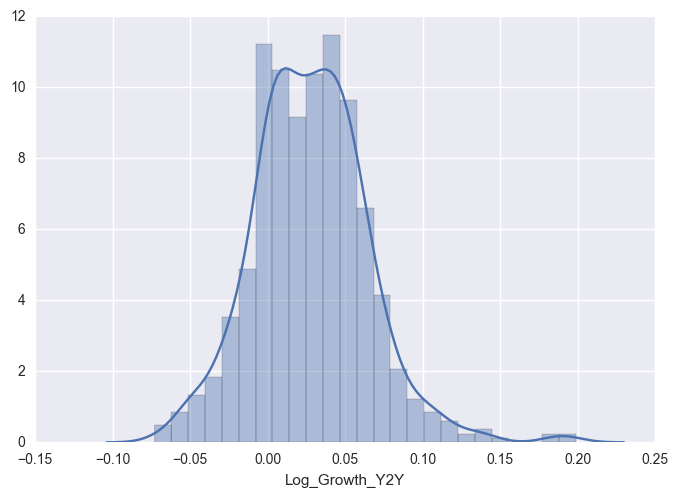

13
105
446
166
24


In [86]:

#Plot the growth distribution

sns.distplot(zip_aggregated['Log_Growth_Y2Y'].dropna())
plt.show()


#Absolute number of businesses in the corresponding intervals of growth

print(sum(zip_aggregated['Log_Growth_Y2Y']<-0.05))
print(sum((zip_aggregated['Log_Growth_Y2Y']>=-0.05)&(zip_aggregated['Log_Growth_Y2Y']<0)))
print(sum((zip_aggregated['Log_Growth_Y2Y']>=0)&(zip_aggregated['Log_Growth_Y2Y']<0.05)))
print(sum((zip_aggregated['Log_Growth_Y2Y']>=0.05)&(zip_aggregated['Log_Growth_Y2Y']<0.10)))
print(sum((zip_aggregated['Log_Growth_Y2Y']>=0.1)))


In [88]:
#reset index

zip_aggregated = zip_aggregated.reset_index()
zip_aggregated.head()

,postal_code,Years,useful,funny,cool,Price,stars_1,stars_2,stars_3,stars_4,stars_5,stars,reviews_perc,prev_stars,MedPrice_sqft(t),MedPrice_sqft_tminus1,MedPrice_sqft_tminus2,MedPrice_sqft_tplus1,Log_Growth_Y2Y
0,15003,2008,2.000,0.500,2.000000,3.000000,0.000000,0.0,0.000000,0.500000,0.500000,4.500000,0.001061,NaN,57.0,57.0,57.0,55.5,-0.026668
1,15003,2009,0.500,0.000,0.500000,2.000000,0.000000,0.0,0.000000,0.500000,0.500000,4.500000,0.000553,4.500000,55.5,57.0,57.0,57.5,0.035402
2,15003,2010,1.625,0.375,0.375000,2.400000,0.000000,0.0,0.125000,0.500000,0.375000,4.250000,0.001275,4.500000,57.5,55.5,57.0,54.0,-0.062801
3,15003,2011,1.200,0.200,0.466667,2.400000,0.066667,0.0,0.066667,0.133333,0.733333,4.466667,0.001285,4.250000,54.0,57.5,55.5,55.5,0.027399
4,15003,2012,1.800,0.450,0.800000,2.111111,0.150000,0.1,0.050000,0.300000,0.400000,3.700000,0.001196,4.466667,55.5,54.0,57.5,57.0,0.026668


# Model Training: Predicting the yearly change in the Medain price per square foot

In [94]:
#Separate data in train and test sets

train_data = zip_aggregated[zip_aggregated['Years']<2015].dropna()
test_data = zip_aggregated[zip_aggregated['Years']>=2015].dropna()
test_data.head()

,postal_code,Years,useful,funny,cool,Price,stars_1,stars_2,stars_3,stars_4,stars_5,stars,reviews_perc,prev_stars,MedPrice_sqft(t),MedPrice_sqft_tminus1,MedPrice_sqft_tminus2,MedPrice_sqft_tplus1,Log_Growth_Y2Y
7,15003,2015,0.901639,0.327869,0.475410,2.076923,0.098361,0.049180,0.032787,0.131148,0.688525,4.262295,0.001568,4.411765,58.0,57.0,57.0,65.0,0.113944
8,15003,2016,0.319444,0.083333,0.194444,2.117647,0.041667,0.041667,0.055556,0.236111,0.625000,4.361111,0.001638,4.262295,65.0,58.0,57.0,66.0,0.015267
11,15009,2015,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000026,5.000000,111.0,104.5,98.0,116.0,0.044060
12,15009,2016,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000023,1.000000,116.0,111.0,104.5,116.5,0.004301
18,15015,2015,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000026,5.000000,133.0,126.5,119.0,143.5,0.075986


In [95]:
#Assign outcome variable

x_train = train_data[train_data.columns[2:17]]
y_train = train_data['Log_Growth_Y2Y']
x_test = test_data[test_data.columns[2:17]]
y_test = test_data['Log_Growth_Y2Y']

## Linear Regression Model:

In [98]:
#Import libraries

from sklearn import linear_model
regr = linear_model.LinearRegression()

#Train model
regr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [99]:
#The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(x_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x_test, y_test))

Coefficients: 
 [-0.00889227 -0.01599779  0.01868342 -0.00330662  0.0243636  -0.00859865
 -0.0244979  -0.00803004  0.016763   -0.0146326   0.27641231 -0.00302613
  0.001622   -0.00261561  0.00101549]
Mean squared error: 0.00
Variance score: -0.39


In [100]:
#predict
regr.predict(x_test)

array([ 0.02400856,  0.03169556,  0.0902373 ,  0.10005022,  0.08970317,
        0.06725497,  0.04100252,  0.0435537 ,  0.05523292,  0.03366865,
        0.03218917,  0.04398818,  0.02808136,  0.05334584,  0.01652562,
        0.02177568,  0.03237921,  0.03337005,  0.03422436,  0.04007412,
        0.02456157,  0.02555612,  0.02741485,  0.03758656,  0.04472043,
        0.02628889,  0.04055859,  0.03292644,  0.03178376,  0.03292779,
        0.04012231,  0.03161686,  0.03523719,  0.04711241,  0.04608814,
        0.04068262,  0.0433616 ,  0.02826433,  0.03786829,  0.03413047,
        0.04664157,  0.02680778,  0.03226584,  0.03094494,  0.04217181,
        0.03937799,  0.04709573,  0.01452903,  0.0393564 ,  0.02742664,
        0.03848508,  0.03521344,  0.04407875,  0.03777138,  0.04589231,
        0.03958065,  0.04035948,  0.04069551,  0.04547341,  0.03046303,
        0.03261673,  0.02857322,  0.0342098 ,  0.01651579,  0.04804361,
        0.0456557 ,  0.01958277,  0.03508857,  0.04470552,  0.03

In [103]:
#Base model: Estimate based on the mean growth and calculate error

mean_growth = np.repeat(y_train.mean(),len(y_test))

np.mean((mean_growth - y_test) ** 2)

0.002136117521521798

In [ ]:

Growth_Y2Y_tminus1 = [(zip_aggregated.ix[i]['MedPrice_sqft(t)']/zip_aggregated.ix[i]['MedPrice_sqft_tminus1'])-1 for i in range(len(zip_aggregated))]
Growth_Y2Y_tminus2 = [(zip_aggregated.ix[i]['MedPrice_sqft_tminus1']/zip_aggregated.ix[i]['MedPrice_sqft_tminus2'])-1 for i in range(len(zip_aggregated))]

In [ ]:
t=-1

stars_Y2Y = [zip_aggregated.ix[i]['stars']/zip_aggregated[((zip_aggregated['postal_code'])==(zip_aggregated.ix[i]['postal_code']))&((zip_aggregated['Years'])==(zip_aggregated.ix[i]['Years']+t))]['stars'].values-1 for i in range(len(zip_aggregated))]

In [ ]:
stars_Y2Y

In [ ]:
zip_aggregated['stars_Y2Y'] = stars_Y2Y
zip_aggregated

In [ ]:
zip_matrix.head()

In [ ]:
#Median
median_values = zip_matrix.groupby(['postal_code', 'Years']).agg(pd.Series.median)

#StdDev
std_values = zip_matrix.groupby(['postal_code', 'Years']).agg(pd.Series.std)

In [ ]:
median_values

In [ ]:
zip_aggregated = zip_aggregated.join(median_values, on = ['postal_code', 'Years'], how = "left", rsuffix="_median")

In [ ]:
zip_aggregated = zip_aggregated.join(std_values, on = ['postal_code', 'Years'], how = "left", rsuffix="_std")

In [ ]:
zip_aggregated

In [ ]:
len(zip_aggregated.dropna())